In [ ]:
from neuralop.models import FNO
import torch
fop_model = FNO(n_modes=(8, 8), hidden_channels=32,
                in_channels=19, out_channels=1)
test_input=torch.randn(1,19,48,48)
out=fop_model(test_input)
print(out.shape)

print(fop_model)

I want to develop a hybrid (part autoencoder, part u-net) model for dense regression.
The input is a multi-channel image, e.g. 9 channels by 128 x 64 pixels. 
The model would take the input and produc
Z,intermediate_output=encoder(X)
X_hat=decoder(Z)
Y_hat=regressor(Z,intemediate_output)
The regressor would be a sequence of convolutional layers with connections to the encoder layers in a typical U-net fashion.
Could you draft a model for this?


In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, in_channels, nf,latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, nf, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(nf, nf*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(nf*2, nf*4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Conv2d(nf*4, latent_dim, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(self.pool(x1)))
        x3 = F.relu(self.conv3(self.pool(x2)))
        z = self.fc(x3)
        return z, [x1, x2, x3]

class Decoder(nn.Module):
    def __init__(self, latent_dim, nf, out_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Conv2d(latent_dim, nf*4, kernel_size=3, padding=1)
        self.deconv1 = nn.ConvTranspose2d(nf*4, nf*2, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(nf*2, nf, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(nf, out_channels, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, z):
        x = self.fc(z)
        x = F.relu(self.deconv1(self.upsample(x)))
        x = F.relu(self.deconv2(self.upsample(x)))
        x_hat =self.deconv3(x)
        return x_hat

class Regressor(nn.Module):
    def __init__(self, latent_dim, nf, out_channels):
        super(Regressor, self).__init__()
        self.fc = nn.Conv2d(latent_dim, nf*4, kernel_size=3, padding=1)
        self.conv1 = nn.ConvTranspose2d(nf*4+nf*2, nf*2, kernel_size=3, padding=1)
        self.conv2 = nn.ConvTranspose2d(nf*2+nf, nf, kernel_size=3, padding=1)
        self.conv3 = nn.ConvTranspose2d(nf, out_channels, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, z, intermediate_outputs):
        x1, x2, x3 = intermediate_outputs
        x = self.fc(z)
        x = self.upsample(x)
        #print(x.shape,x2.shape)
        x = torch.concat([x, x2], dim=1)
        x = F.relu(self.conv1(x))
        x = self.upsample(x)
        x = torch.concat([x, x1], dim=1)
        #print(x.shape,'[x,x1]')
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        y_hat = x
        return y_hat

class HybridModel(nn.Module):
    def __init__(self, in_channels, nf, latent_dim, out_channels):
        super(HybridModel, self).__init__()
        self.encoder = Encoder(in_channels, nf, latent_dim)
        self.decoder = Decoder(latent_dim, nf, in_channels)
        self.regressor = Regressor(latent_dim, nf, out_channels)

    def forward(self, x):
        z, intermediate_outputs = self.encoder(x)
        x_hat = self.decoder(z)
        y_hat = self.regressor(z, intermediate_outputs)
        return x_hat, y_hat

# Example usage
in_channels = 9
latent_dim = 128
out_channels = 9
#model = HybridModel(in_channels, latent_dim, out_channels)
nx = 128
ny = 64
nf = 16
model_encoder = Encoder(in_channels, nf, latent_dim)
model_decoder = Decoder(latent_dim, nf, out_channels)
# Example input
x = torch.randn(1, in_channels, 128, 64)
#x_hat = model(x)
z, intermediate_outputs = model_encoder(x)

#print(x_hat.shape)
#print(z.shape)
#for x in intermediate_outputs:
#    print('int_shape',x.shape)

hybrid_model = HybridModel(in_channels, nf, latent_dim, out_channels)
torch.onnx.export(hybrid_model, x, "hybrid_model.onnx", verbose=True, input_names = ['input'], output_names = ['output1', 'output2'])

Exported graph: graph(%input : Float(1, 9, 128, 64, strides=[73728, 8192, 64, 1], requires_grad=0, device=cpu),
      %encoder.conv1.weight : Float(16, 9, 3, 3, strides=[81, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.conv1.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %encoder.conv2.weight : Float(32, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.conv2.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %encoder.conv3.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.conv3.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %encoder.fc.weight : Float(128, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.fc.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %decoder.fc.weight : Float(64, 128, 3, 3, strides=[1152, 9, 3, 1], requires_grad=1, device=cpu),
      %decoder.fc.bias : Float(64, strides=[1], req

In [29]:
import glob
import numpy as np
fs=sorted(glob.glob("tb_patches_2020*.npz"))
X=[]
col_wv=[]
col_cloud_liq=[]
near_sfc_rain=[]
for f in fs[:80]:
    d=np.load(f)
    X.extend(d['tb_patches'].astype(np.float32))
    col_wv.extend(d['col_wv_OE'])
    d_temp=d['near_sfc_rain']
    a=np.nonzero(d_temp>-0.01)
    d_temp[a]=np.log10(1+d_temp[a]/0.1)
    near_sfc_rain.extend(d_temp.copy())
    col_cloud_liq.extend(d['col_cloud_liquid'])
X=np.array(X)
X=np.moveaxis(X,3,1)
X=X.astype(np.float32)
print(X.shape)

(12838, 9, 128, 64)


In [30]:
col_wv=np.array(col_wv)

np.mean(col_wv[a]),np.std(col_wv[a])
col_cloud_liq=np.array(col_cloud_liq)
a=np.nonzero(col_cloud_liq>=0)
np.mean(col_cloud_liq[a]),np.std(col_cloud_liq[a])
col_cloud_liq_mean=np.mean(col_cloud_liq[a])
col_cloud_liq_std=np.std(col_cloud_liq[a])
near_sfc_rain=np.array(near_sfc_rain)
a=np.nonzero(near_sfc_rain>=0)
np.mean(near_sfc_rain[a]),np.std(near_sfc_rain[a])
near_sfc_rain_mean=np.mean(near_sfc_rain[a])
near_sfc_rain_std=np.std(near_sfc_rain[a])
a=np.nonzero(col_wv>=0)
col_wv_mean=np.mean(col_wv[a])
col_wv_std=np.std(col_wv[a])
y_target=np.concatenate([col_wv[:,np.newaxis,:,:],col_cloud_liq[:,np.newaxis,:,:],near_sfc_rain[:,np.newaxis,:]],axis=1)

mask_y=(y_target>=0).astype(np.float32)
y_target[:,0,:,:]=(y_target[:,0,:,:]-col_wv_mean)/col_wv_std
y_target[:,1,:,:]=(y_target[:,1,:,:]-col_cloud_liq_mean)/col_cloud_liq_std
y_target[:,2,:,:]=(y_target[:,2,:,:]-near_sfc_rain_mean)/near_sfc_rain_std

near_sfc_rain=np.array(near_sfc_rain)
col_wv=np.array(col_wv)
col_cloud_liq=np.array(col_cloud_liq)
X_mean=X.mean(axis=0)
X_std=X.std(axis=0)
X_norm=(X-X_mean)/X_std
import pickle
d={'X_mean':X_mean,'X_std':X_std,'col_wv_mean':col_wv_mean,'col_wv_std':col_wv_std,'col_cloud_liq_mean':col_cloud_liq_mean,'col_cloud_liq_std':col_cloud_liq_std,'near_sfc_rain_mean':near_sfc_rain_mean,'near_sfc_rain_std':near_sfc_rain_std}
pickle.dump(d,open('tb_target_mean_std.pkl','wb'))



In [53]:
import torch
n_all=X_norm.shape[0]
nt=int(n_all*0.8)
X_torch=torch.tensor(X_norm[:nt],dtype=torch.float32)
y_torch=torch.tensor(y_target[:nt],dtype=torch.float32)
mask_torch=torch.tensor(mask_y[:nt],dtype=torch.float32) 
model = HybridModel(in_channels=9, nf=16, latent_dim=16, out_channels=3)
dataset = torch.utils.data.TensorDataset(X_torch, y_torch,mask_torch)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [54]:

n_epochs = 5
for epoch in range(n_epochs):
    avg_loss = 0
    for inputs, target, mask_ in dataloader:
        optimizer.zero_grad()
        outputs, y_ = model(inputs)
        loss1 = criterion(outputs, inputs)
        loss2 = criterion(y_*mask_, target*mask_)
        loss=loss1+loss2
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss/len(dataloader)}")

Epoch 1/5, Loss: 0.28787616036855546
Epoch 2/5, Loss: 0.15871282834037442
Epoch 3/5, Loss: 0.14581949068842648
Epoch 4/5, Loss: 0.1308806903683508
Epoch 5/5, Loss: 0.1265457313844348


In [56]:
#scripted_model = torch.jit.script(model)
X_test_torch=torch.tensor(X_norm[nt:],dtype=torch.float32)
#scripted_model.save("model_hybrid_2outputs_retrained.pt")
#model=torch.jit.script(model)
x_rec, y_pred=model(X_test_torch)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 32 for tensor number 1 in the list.

In [57]:
torch.onnx.export(model, X_test_torch[:1,:,:,:], "model_hybrid_2outputs", verbose=True, input_names=['input'], output_names=['output1','output2'])

Exported graph: graph(%input : Float(1, 9, 128, 64, strides=[73728, 1, 576, 9], requires_grad=0, device=cpu),
      %encoder.conv1.weight : Float(16, 9, 3, 3, strides=[81, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.conv1.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %encoder.conv2.weight : Float(32, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.conv2.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %encoder.conv3.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.conv3.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %encoder.fc.weight : Float(16, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=1, device=cpu),
      %encoder.fc.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %decoder.fc.weight : Float(64, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cpu),
      %decoder.fc.bias : Float(64, strides=[1], requires_

0.9515082 0.9310476
0.7816973 0.7929131
2.7854583 2.1225977
0.9850911541276295
0.8748352806303226
0.8127180724370588


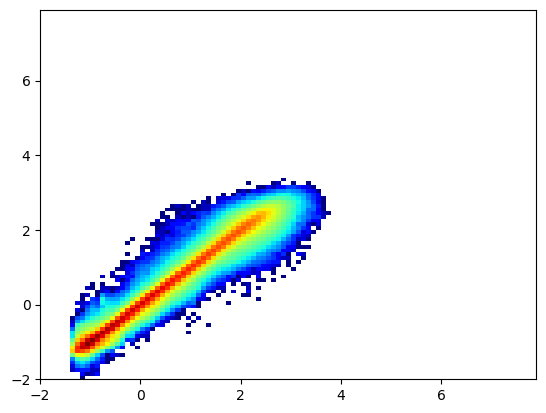

In [59]:
y_pred_numpy=y_pred.detach().numpy()
y_target_test=y_target[nt:]
col_wv_test=col_wv[nt:]
a=np.nonzero(col_wv_test[:,:,:]>0)
import matplotlib.pyplot as plt
import matplotlib
h2=plt.hist2d(y_target_test[:,0,:,:][a],y_pred_numpy[:,0,:,:][a],bins=np.arange(100)*0.1-2,norm=matplotlib.colors.LogNorm(),cmap='jet')
np.corrcoef(y_target_test[:,0,:,:][a].flatten(),y_pred_numpy[:,0,:,:][a].flatten())
for i in range(3):
    a=np.nonzero(y_target_test[:,i,:,:]>0)
    print(y_target_test[:,i,:,:][a].mean(),y_pred_numpy[:,i,:,:][a].mean())

for i in range(3):
    a=np.nonzero(y_target_test[:,i,:,:]>0)
    print(np.corrcoef(y_target_test[:,i,:,:][a].flatten(),y_pred_numpy[:,i,:,:][a].flatten())[0,1])